# Deep Reinforcement Learning for Portfolio Optimization - EIIE Architecture


This experiement demonstrates the application of deep reinforcement learning (DRL) techniques for portfolio optimization.


- Policy network architecture: **EIIE backbone**
- Compares `A2C`, `PPO`, `SAC`, `DDPG`, `TD3` all with simple MLPs

## Dependencies


In [1]:
# ! pip install pandas numpy matplotlib \
#                stable-baselines3 \
#                PyPortfolioOpt \
#                pandas_market_calendars quantstats gymnasium \
#                git+https://github.com/AI4Finance-Foundation/FinRL.git -q

In [2]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from scipy.optimize import minimize

import torch

from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import (
    PortfolioOptimizationEnv,
)
from finrl.agents.portfolio_optimization.models import DRLAgent as POAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

In [3]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [5]:
experiment_name = "portfolio_optimization_eiie_pg"
results_dir = f"results/models/{experiment_name}"
os.makedirs(results_dir, exist_ok=True)

## Data loading and pre-processing


Define training and trading/test periods


In [6]:
start_date = "2015-01-01"
end_date = (datetime.now() - pd.Timedelta(days=1)).strftime("%Y-%m-%d")  # Yesterday

trade_period = 2  # 2 years for testing
train_period = 10  # 10 years for training

train_end_date = (
    datetime.strptime(end_date, "%Y-%m-%d") - timedelta(days=trade_period * 365)
).strftime("%Y-%m-%d")
train_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") - timedelta(days=train_period * 365)
).strftime("%Y-%m-%d")
test_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") + timedelta(days=1)
).strftime("%Y-%m-%d")

train_dates = (train_start_date, train_end_date)
test_dates = (test_start_date, end_date)

print(f"Training period: {train_dates}")
print(f"Testing period: {test_dates}")

Training period: ('2013-05-03', '2023-05-01')
Testing period: ('2023-05-02', '2025-04-30')


- Fetch historical stock data for a given list of tickers within a specified date range.
- We use the DOW_30_TICKER stocks
- The data includes `date`, `close`, `high`, `low`, `open`, `volume`, and `tic` (ticker symbol).


In [7]:
def download_data(tickers, start_date, end_date):
    print(f"Downloading {start_date} → {end_date}")
    return YahooDownloader(
        start_date=start_date, end_date=end_date, ticker_list=tickers
    ).fetch_data()

tickers = config_tickers.DOW_30_TICKER
raw_df = download_data(tickers, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (76821, 8)


---

### Feature Engineering

We apply feature engineering to the dataset of stock data:

- Add technical indicators (e.g., moving averages, RSI).
- Calculate turbulence indicators, which measure market volatility.

This Enhance the dataset with features that are critical for modeling market dynamics and making informed trading decisions.


In [8]:
def preprocess_data(df):
    fe = FeatureEngineer(use_technical_indicator=True, use_turbulence=True)
    return fe.preprocess_data(df)

df_feat = preprocess_data(raw_df)

Successfully added technical indicators
Successfully added turbulence index


## Covariance & Returns for State


- Calculate the rolling covariance matrices and daily returns for the given dataset of stock prices.
- This prepares the state representation (the state of the portfolio) for the RL models in the RL environments for portfolio optimization.
- The **rolling covariance matrices** (`cov_list`) capture the relationships between asset returns, while the daily returns (`return_list`) provide information about recent price movements.
- These metrics are critical for modeling the dynamics of the financial market and making informed trading decisions.


In [9]:
def compute_covariance_and_returns(df_feat, lookback=252):
    df_sorted = df_feat.sort_values(["date", "tic"], ignore_index=True)
    df_sorted.index = df_sorted.date.factorize()[0]
    cov_list, return_list = [], []

    dates = df_sorted.date.unique()
    for i in range(lookback, len(dates)):
        win = df_sorted.loc[i - lookback : i]
        pm = win.pivot_table(index="date", columns="tic", values="close")
        rm = pm.pct_change().dropna()
        cov_list.append(rm.cov().values)
        return_list.append(rm)
    df_cov = pd.DataFrame(
        {"date": dates[lookback:], "cov_list": cov_list, "return_list": return_list}
    )

    return pd.merge(df_feat, df_cov, on="date", how="left").dropna(subset=["cov_list"])


df_all = compute_covariance_and_returns(df_feat)

## Train/Trade split


In [10]:
def split_data(df_all, train_dates, test_dates):
    train = data_split(df_all, *train_dates)
    test = data_split(df_all, *test_dates)
    return train, test


train_df, test_df = split_data(df_all, train_dates, test_dates)

## Environment setup


- Create instances of the **PortfolioOptimizationEnv** class for both training and testing datasets.
- It also wrap the training environment for use with Stable-Baselines3 (SB3).


In [11]:
def initialize_portfolio_env(df):
    env = PortfolioOptimizationEnv(
        df,
        initial_amount=100_000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        normalize_df=None,
        new_gym_api=True,
    )

    env.df = df.reset_index(drop=True)

    return env


train_env = initialize_portfolio_env(train_df)

## Training


- Set PolicyGradient algorithm and EIIE architecture arguments


In [12]:
model_kwargs = {"lr": 0.01, "policy": EIIE}
# Set EIIE architecture arguments
policy_kwargs = {"k_size": 3, "time_window": 50}

model = POAgent(train_env).get_model("pg", device, model_kwargs, policy_kwargs)

- Train the model


In [13]:
def train():
    start_time = time.time()

    trained_model = POAgent.train_model(model, episodes=64)

    end_time = time.time()
    training_duration = (end_time - start_time) / 60
    print(f"Training completed in {training_duration:.2f} minutes.")
    
    return trained_model, training_duration

In [14]:
# TODO: Turn to False after first run to avoid retraining and just analyse the results
retrain = True

model_path = f"{results_dir}/eeie_pg.pth"

In [15]:
if retrain:
    trained_model, training_duration = train()

  0%|          | 0/64 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 241958.03125
Final accumulative portfolio value: 2.4195802211761475
Maximum DrawDown: -0.32491971472898906
Sharpe ratio: 0.779104774752295


  2%|▏         | 1/64 [00:18<19:23, 18.47s/it]

Initial portfolio value:100000
Final portfolio value: 243226.9375
Final accumulative portfolio value: 2.432269334793091
Maximum DrawDown: -0.326904511907282
Sharpe ratio: 0.7790439621415535


  3%|▎         | 2/64 [00:36<18:50, 18.23s/it]

Initial portfolio value:100000
Final portfolio value: 244528.3125
Final accumulative portfolio value: 2.4452831745147705
Maximum DrawDown: -0.3288396275229466
Sharpe ratio: 0.7792173763109954


  6%|▋         | 4/64 [01:13<18:06, 18.11s/it]

Initial portfolio value:100000
Final portfolio value: 245484.40625
Final accumulative portfolio value: 2.4548439979553223
Maximum DrawDown: -0.3301438515626024
Sharpe ratio: 0.7795635325333519


  8%|▊         | 5/64 [01:30<17:38, 17.95s/it]

Initial portfolio value:100000
Final portfolio value: 246011.328125
Final accumulative portfolio value: 2.460113286972046
Maximum DrawDown: -0.3308241708273558
Sharpe ratio: 0.7798182818748524
Initial portfolio value:100000
Final portfolio value: 246254.90625
Final accumulative portfolio value: 2.4625489711761475
Maximum DrawDown: -0.3311611136386109
Sharpe ratio: 0.7798900085059444


  9%|▉         | 6/64 [01:47<17:07, 17.72s/it]

Initial portfolio value:100000
Final portfolio value: 246388.859375
Final accumulative portfolio value: 2.463888645172119
Maximum DrawDown: -0.3313350375546169
Sharpe ratio: 0.7799478168943206


 11%|█         | 7/64 [02:06<17:00, 17.90s/it]

Initial portfolio value:100000
Final portfolio value: 246469.15625
Final accumulative portfolio value: 2.464691638946533
Maximum DrawDown: -0.33143565865928737
Sharpe ratio: 0.779990986019277


 12%|█▎        | 8/64 [02:24<16:47, 17.99s/it]

Initial portfolio value:100000
Final portfolio value: 246522.359375
Final accumulative portfolio value: 2.465223550796509
Maximum DrawDown: -0.331499555199669
Sharpe ratio: 0.7800268731583969


 14%|█▍        | 9/64 [02:42<16:37, 18.13s/it]

Initial portfolio value:100000
Final portfolio value: 246536.96875
Final accumulative portfolio value: 2.465369701385498
Maximum DrawDown: -0.3315411230148486
Sharpe ratio: 0.7799875101886764


 16%|█▌        | 10/64 [03:00<16:14, 18.04s/it]

Initial portfolio value:100000
Final portfolio value: 246561.453125
Final accumulative portfolio value: 2.4656145572662354
Maximum DrawDown: -0.33156907558560533
Sharpe ratio: 0.7800056167672579


 17%|█▋        | 11/64 [03:18<15:59, 18.10s/it]

Initial portfolio value:100000
Final portfolio value: 246574.671875
Final accumulative portfolio value: 2.4657466411590576
Maximum DrawDown: -0.3315890711236982
Sharpe ratio: 0.7800056350243093


 19%|█▉        | 12/64 [03:36<15:35, 18.00s/it]

Initial portfolio value:100000
Final portfolio value: 246584.96875
Final accumulative portfolio value: 2.4658496379852295
Maximum DrawDown: -0.33160405440131446
Sharpe ratio: 0.7800088857631983


 20%|██        | 13/64 [03:55<15:29, 18.23s/it]

Initial portfolio value:100000
Final portfolio value: 246594.8125
Final accumulative portfolio value: 2.4659481048583984
Maximum DrawDown: -0.3316153296156046
Sharpe ratio: 0.780013359328275


 22%|██▏       | 14/64 [04:14<15:29, 18.59s/it]

Initial portfolio value:100000
Final portfolio value: 246598.328125
Final accumulative portfolio value: 2.4659833908081055
Maximum DrawDown: -0.3316272626346287
Sharpe ratio: 0.7800035054477961


 23%|██▎       | 15/64 [04:34<15:27, 18.94s/it]

Initial portfolio value:100000
Final portfolio value: 246609.703125
Final accumulative portfolio value: 2.466097116470337
Maximum DrawDown: -0.331633507977533
Sharpe ratio: 0.7800230588552564


 25%|██▌       | 16/64 [04:54<15:24, 19.26s/it]

Initial portfolio value:100000
Final portfolio value: 246620.0
Final accumulative portfolio value: 2.466200113296509
Maximum DrawDown: -0.33164132498710674
Sharpe ratio: 0.7800398617380421


 27%|██▋       | 17/64 [05:13<15:01, 19.18s/it]

Initial portfolio value:100000
Final portfolio value: 246618.328125
Final accumulative portfolio value: 2.4661831855773926
Maximum DrawDown: -0.3316467499730076
Sharpe ratio: 0.7800253567938591


 28%|██▊       | 18/64 [05:31<14:25, 18.82s/it]

Initial portfolio value:100000
Final portfolio value: 246615.59375
Final accumulative portfolio value: 2.466156005859375
Maximum DrawDown: -0.33165165295531485
Sharpe ratio: 0.7800066152602805


 30%|██▉       | 19/64 [05:50<14:03, 18.75s/it]

Initial portfolio value:100000
Final portfolio value: 246625.90625
Final accumulative portfolio value: 2.466259002685547
Maximum DrawDown: -0.33165603836999447
Sharpe ratio: 0.7800309455993006


 31%|███▏      | 20/64 [06:07<13:21, 18.21s/it]

Initial portfolio value:100000
Final portfolio value: 246628.1875
Final accumulative portfolio value: 2.4662818908691406
Maximum DrawDown: -0.33165915616953756
Sharpe ratio: 0.7800282563833114


 34%|███▍      | 22/64 [06:42<12:29, 17.85s/it]

Initial portfolio value:100000
Final portfolio value: 246625.46875
Final accumulative portfolio value: 2.466254711151123
Maximum DrawDown: -0.33166301976375756
Sharpe ratio: 0.7800133777888935
Initial portfolio value:100000
Final portfolio value: 246628.875
Final accumulative portfolio value: 2.4662888050079346
Maximum DrawDown: -0.3316655800781062
Sharpe ratio: 0.7800202707516376


 38%|███▊      | 24/64 [07:16<11:35, 17.39s/it]

Initial portfolio value:100000
Final portfolio value: 246630.40625
Final accumulative portfolio value: 2.466304063796997
Maximum DrawDown: -0.3316662137451547
Sharpe ratio: 0.7800234773689273


 39%|███▉      | 25/64 [07:32<11:09, 17.16s/it]

Initial portfolio value:100000
Final portfolio value: 246628.171875
Final accumulative portfolio value: 2.4662816524505615
Maximum DrawDown: -0.3316681609220995
Sharpe ratio: 0.7800119238756772
Initial portfolio value:100000
Final portfolio value: 246635.0
Final accumulative portfolio value: 2.4663500785827637
Maximum DrawDown: -0.33166950894101044
Sharpe ratio: 0.780029789048662


 42%|████▏     | 27/64 [08:08<10:44, 17.42s/it]

Initial portfolio value:100000
Final portfolio value: 246627.8125
Final accumulative portfolio value: 2.466278076171875
Maximum DrawDown: -0.33167025520554383
Sharpe ratio: 0.7800059716646378
Initial portfolio value:100000
Final portfolio value: 246634.390625
Final accumulative portfolio value: 2.466343879699707
Maximum DrawDown: -0.33167289163776836
Sharpe ratio: 0.7800215084453286


 44%|████▍     | 28/64 [08:25<10:20, 17.24s/it]

Initial portfolio value:100000
Final portfolio value: 246636.40625
Final accumulative portfolio value: 2.4663641452789307
Maximum DrawDown: -0.33167469701969254
Sharpe ratio: 0.7800242903810413


 45%|████▌     | 29/64 [08:43<10:15, 17.60s/it]

Initial portfolio value:100000
Final portfolio value: 246635.3125
Final accumulative portfolio value: 2.466353178024292
Maximum DrawDown: -0.3316758684420831
Sharpe ratio: 0.7800167397436703


 48%|████▊     | 31/64 [09:18<09:38, 17.53s/it]

Initial portfolio value:100000
Final portfolio value: 246636.265625
Final accumulative portfolio value: 2.466362714767456
Maximum DrawDown: -0.33167666997088985
Sharpe ratio: 0.7800207611771497


 50%|█████     | 32/64 [09:36<09:23, 17.61s/it]

Initial portfolio value:100000
Final portfolio value: 246630.875
Final accumulative portfolio value: 2.466308832168579
Maximum DrawDown: -0.3316779956960607
Sharpe ratio: 0.7799979186649119
Initial portfolio value:100000
Final portfolio value: 246647.234375
Final accumulative portfolio value: 2.4664723873138428
Maximum DrawDown: -0.33167825680738405
Sharpe ratio: 0.7800486861115034


 52%|█████▏    | 33/64 [09:54<09:07, 17.65s/it]

Initial portfolio value:100000
Final portfolio value: 246637.578125
Final accumulative portfolio value: 2.4663758277893066
Maximum DrawDown: -0.3316798553271817
Sharpe ratio: 0.7800171458803844


 53%|█████▎    | 34/64 [10:11<08:44, 17.50s/it]

Initial portfolio value:100000
Final portfolio value: 246632.234375
Final accumulative portfolio value: 2.466322422027588
Maximum DrawDown: -0.331681228305009
Sharpe ratio: 0.7799993337856941


 55%|█████▍    | 35/64 [10:29<08:34, 17.75s/it]

Initial portfolio value:100000
Final portfolio value: 246635.640625
Final accumulative portfolio value: 2.4663565158843994
Maximum DrawDown: -0.3316826853960526
Sharpe ratio: 0.7800048113583752


 56%|█████▋    | 36/64 [10:48<08:27, 18.14s/it]

Initial portfolio value:100000
Final portfolio value: 246640.34375
Final accumulative portfolio value: 2.4664034843444824
Maximum DrawDown: -0.33168305254506636
Sharpe ratio: 0.7800180618309589


 59%|█████▉    | 38/64 [11:25<07:50, 18.08s/it]

Initial portfolio value:100000
Final portfolio value: 246639.15625
Final accumulative portfolio value: 2.4663915634155273
Maximum DrawDown: -0.33168359295410244
Sharpe ratio: 0.7800145605879223


 61%|██████    | 39/64 [11:41<07:21, 17.65s/it]

Initial portfolio value:100000
Final portfolio value: 246644.8125
Final accumulative portfolio value: 2.4664480686187744
Maximum DrawDown: -0.3316833875693488
Sharpe ratio: 0.7800303845742651


 62%|██████▎   | 40/64 [11:58<06:55, 17.31s/it]

Initial portfolio value:100000
Final portfolio value: 246640.53125
Final accumulative portfolio value: 2.4664053916931152
Maximum DrawDown: -0.3316834196914016
Sharpe ratio: 0.7800168950771549


 64%|██████▍   | 41/64 [12:15<06:36, 17.24s/it]

Initial portfolio value:100000
Final portfolio value: 246644.5625
Final accumulative portfolio value: 2.4664456844329834
Maximum DrawDown: -0.33168261602786864
Sharpe ratio: 0.7800308042900358


 66%|██████▌   | 42/64 [12:31<06:15, 17.05s/it]

Initial portfolio value:100000
Final portfolio value: 246644.078125
Final accumulative portfolio value: 2.4664406776428223
Maximum DrawDown: -0.33168411828089095
Sharpe ratio: 0.7800283707597532
Initial portfolio value:100000
Final portfolio value: 246643.203125
Final accumulative portfolio value: 2.4664320945739746
Maximum DrawDown: -0.33168612171183043
Sharpe ratio: 0.7800230852247424


 67%|██████▋   | 43/64 [12:49<06:01, 17.22s/it]

Initial portfolio value:100000
Final portfolio value: 246641.34375
Final accumulative portfolio value: 2.4664134979248047
Maximum DrawDown: -0.331685486125071
Sharpe ratio: 0.7800158392425175


 69%|██████▉   | 44/64 [13:07<05:49, 17.47s/it]

Initial portfolio value:100000
Final portfolio value: 246644.859375
Final accumulative portfolio value: 2.4664485454559326
Maximum DrawDown: -0.3316857489752736
Sharpe ratio: 0.7800267432566277


 72%|███████▏  | 46/64 [13:42<05:12, 17.37s/it]

Initial portfolio value:100000
Final portfolio value: 246642.234375
Final accumulative portfolio value: 2.4664223194122314
Maximum DrawDown: -0.33168687063326585
Sharpe ratio: 0.7800170288425607


 73%|███████▎  | 47/64 [13:58<04:50, 17.11s/it]

Initial portfolio value:100000
Final portfolio value: 246641.0
Final accumulative portfolio value: 2.466409921646118
Maximum DrawDown: -0.33168658721300515
Sharpe ratio: 0.7800123490651


 75%|███████▌  | 48/64 [14:15<04:31, 16.97s/it]

Initial portfolio value:100000
Final portfolio value: 246650.234375
Final accumulative portfolio value: 2.4665024280548096
Maximum DrawDown: -0.33168640751210887
Sharpe ratio: 0.7800410096789421


 77%|███████▋  | 49/64 [14:32<04:14, 16.94s/it]

Initial portfolio value:100000
Final portfolio value: 246639.9375
Final accumulative portfolio value: 2.4663994312286377
Maximum DrawDown: -0.3316871354539118
Sharpe ratio: 0.7800073956272122


 78%|███████▊  | 50/64 [14:48<03:55, 16.80s/it]

Initial portfolio value:100000
Final portfolio value: 246642.84375
Final accumulative portfolio value: 2.466428518295288
Maximum DrawDown: -0.3316874047580318
Sharpe ratio: 0.7800171538995524


 80%|███████▉  | 51/64 [15:05<03:37, 16.76s/it]

Initial portfolio value:100000
Final portfolio value: 246643.90625
Final accumulative portfolio value: 2.4664390087127686
Maximum DrawDown: -0.3316878879506595
Sharpe ratio: 0.7800183822866722


 81%|████████▏ | 52/64 [15:21<03:20, 16.67s/it]

Initial portfolio value:100000
Final portfolio value: 246640.1875
Final accumulative portfolio value: 2.4664018154144287
Maximum DrawDown: -0.3316886120349454
Sharpe ratio: 0.7800073052211713
Initial portfolio value:100000
Final portfolio value: 246645.609375
Final accumulative portfolio value: 2.466456174850464
Maximum DrawDown: -0.3316882629703559
Sharpe ratio: 0.7800212924019938


 83%|████████▎ | 53/64 [15:40<03:10, 17.32s/it]

Initial portfolio value:100000
Final portfolio value: 246649.921875
Final accumulative portfolio value: 2.4664993286132812
Maximum DrawDown: -0.33168903060928245
Sharpe ratio: 0.7800380223718275


 84%|████████▍ | 54/64 [15:58<02:55, 17.57s/it]

Initial portfolio value:100000
Final portfolio value: 246649.75
Final accumulative portfolio value: 2.4664974212646484
Maximum DrawDown: -0.331687874752034
Sharpe ratio: 0.780036388360257


 88%|████████▊ | 56/64 [16:40<02:34, 19.25s/it]

Initial portfolio value:100000
Final portfolio value: 246648.46875
Final accumulative portfolio value: 2.466484785079956
Maximum DrawDown: -0.33168855043215595
Sharpe ratio: 0.7800311919516587


 89%|████████▉ | 57/64 [16:57<02:10, 18.66s/it]

Initial portfolio value:100000
Final portfolio value: 246645.15625
Final accumulative portfolio value: 2.466451644897461
Maximum DrawDown: -0.33168888663220564
Sharpe ratio: 0.7800213493491944
Initial portfolio value:100000
Final portfolio value: 246643.390625
Final accumulative portfolio value: 2.4664340019226074
Maximum DrawDown: -0.3316900206556683
Sharpe ratio: 0.7800144116733955


 91%|█████████ | 58/64 [17:14<01:48, 18.16s/it]

Initial portfolio value:100000
Final portfolio value: 246648.171875
Final accumulative portfolio value: 2.4664816856384277
Maximum DrawDown: -0.33168891635701625
Sharpe ratio: 0.7800295012887586


 94%|█████████▍| 60/64 [17:49<01:11, 17.95s/it]

Initial portfolio value:100000
Final portfolio value: 246643.015625
Final accumulative portfolio value: 2.466430187225342
Maximum DrawDown: -0.33168882248661224
Sharpe ratio: 0.7800130980821982


 95%|█████████▌| 61/64 [18:07<00:53, 17.81s/it]

Initial portfolio value:100000
Final portfolio value: 246651.953125
Final accumulative portfolio value: 2.466519594192505
Maximum DrawDown: -0.33168816228869613
Sharpe ratio: 0.7800425525225821
Initial portfolio value:100000
Final portfolio value: 246644.75
Final accumulative portfolio value: 2.466447591781616
Maximum DrawDown: -0.33168909094476695
Sharpe ratio: 0.780020943066229


 97%|█████████▋| 62/64 [18:24<00:35, 17.58s/it]

Initial portfolio value:100000
Final portfolio value: 246639.03125
Final accumulative portfolio value: 2.466390371322632
Maximum DrawDown: -0.3316891845137183
Sharpe ratio: 0.7800040868527628


 98%|█████████▊| 63/64 [18:41<00:17, 17.43s/it]

Initial portfolio value:100000
Final portfolio value: 246643.84375
Final accumulative portfolio value: 2.4664385318756104
Maximum DrawDown: -0.3316895202732806
Sharpe ratio: 0.7800157571766476


100%|██████████| 64/64 [18:58<00:00, 17.80s/it]

Training completed in 18.98 minutes.


In [16]:
if retrain:
    # Save the trained model
    torch.save(trained_model.train_policy.state_dict(),model_path)
    print(f"Model saved to {model_path}")
    
    # Save training times
    training_times_df = pd.DataFrame(
        [{"model": "EIIE_PG", "training_duration (min)": training_duration}]
    )
    training_times_df.to_csv(f"{results_dir}/training_times.csv", index=False)

    # Display training summary
    print("Training summary:")
    display(training_times_df)

Model saved to results/models/portfolio_optimization_eiie_pg/eeie_pg.pth
Training summary:


,model,training_duration (min)
0,EIIE_PG,18.984421


## Backtesting


In [17]:
policy = EIIE(time_window=50, device=device)
policy.load_state_dict(torch.load(model_path, map_location=device))
# policy = policy.to(device)
# policy.eval()
print("Model loaded and ready for evaluation.")
print("Evaluating model on test data...")

test_env = initialize_portfolio_env(test_df.reset_index(drop=True))

Model loaded and ready for evaluation.
Evaluating model on test data...


In [18]:
# # Generate quantstats report for the RL strategy
# def generate_quantstats_report(env, policy, test_df):
#     env.reset()
#     state = env.reset()
#     actions = []
#     rewards = []
#     done = False

#     while not done:
#         # Assuming last_action is initialized as a uniform distribution
#         if 'last_action' not in locals():
#             last_action = np.ones(env.action_space.shape[0], dtype=np.float32) / env.action_space.shape[0]
        
#         # Pass last_action to the policy
#         action = policy(state[None, ...], last_action[None, ...])
#         last_action = action.flatten()  # Update last_action for the next step
#         actions.append(action)
#         next_state, reward, terminated, truncated, info = env.step(action)
#         done = terminated or truncated
#         state = next_state
#         rewards.append(reward)

#     # Convert actions and rewards to DataFrame
#     actions_df = pd.DataFrame(actions, columns=test_df.tic.unique())
#     actions_df["date"] = test_df.date.unique()[env.time_window:]
#     actions_df.set_index("date", inplace=True)

#     # Calculate portfolio returns
#     portfolio_returns = (actions_df * test_df.return_list).sum(axis=1)

#     # Generate quantstats report
#     import quantstats as qs

#     # qs.reports.html(portfolio_returns, output=f"{results_dir}/quantstats_report.html")
#     print("Quantstats report generated.")
    
# generate_quantstats_report(test_env, policy, test_df)

In [19]:
def portfolio_test(env, policy, initial_last_action=None):
    obs, _ = env.reset()
    obs = np.asarray(obs, dtype=np.float32)

    # Initial last_action
    if initial_last_action is None:
        action_dim = env.action_space.shape[0]
        last_action = np.ones(action_dim, dtype=np.float32) / action_dim
    else:
        last_action = np.asarray(initial_last_action).flatten().astype(np.float32)

    done = False
    transitions = []

    while not done:
        # Create batches
        obs_batch = obs[None, ...]
        la_batch = last_action[None, ...]

        # Policy forward
        action = policy(obs_batch, la_batch)
        action = np.asarray(action).flatten().astype(np.float32)

        # Step
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = bool(terminated or truncated)

        next_obs = np.asarray(next_obs, dtype=np.float32)

        # Record
        transitions.append(
            {
                "obs": obs,
                "last_action": last_action,
                "action": action,
                "reward": float(reward),
                "info": info,
            }
        )

        # Advance
        obs = next_obs
        last_action = action

    return transitions


transitions = portfolio_test(test_env, policy)

print(f"Collected {len(transitions)} steps.")
print("Rewards:", [t["reward"] for t in transitions])

Initial portfolio value:100000
Final portfolio value: 119838.8046875
Final accumulative portfolio value: 1.1983880996704102
Maximum DrawDown: -0.14796559215407346
Sharpe ratio: 0.80267241027913
Collected 451 steps.
Rewards: [-0.0023511252366006374, -5.722062269342132e-06, 0.008162236772477627, 0.005791431292891502, 0.004802240990102291, 0.002063052263110876, 0.0038041146472096443, 0.0015307862777262926, 0.004212554078549147, -0.00763191981241107, 0.006032473873347044, 0.0020216519478708506, -3.933914285880746e-06, -0.00844469852745533, -0.0019675763323903084, -0.004924601409584284, 0.00947478786110878, -0.003430462209507823, -0.005006666295230389, 0.0029522664844989777, 0.0032888154964894056, 0.0006685405969619751, -0.011536548845469952, -0.005734582897275686, -0.00665321946144104, 0.001311871805228293, -0.001192505587823689, -0.004942691419273615, 0.006362539250403643, -0.012836839072406292, 0.007649060804396868, 0.006311365868896246, 0.009204336442053318, 0.0019540756475180387, -0.00

In [20]:
# Inspect rewards or info:
infosrewards = [t["reward"] for t in transitions]
infos = [t["info"] for t in transitions]

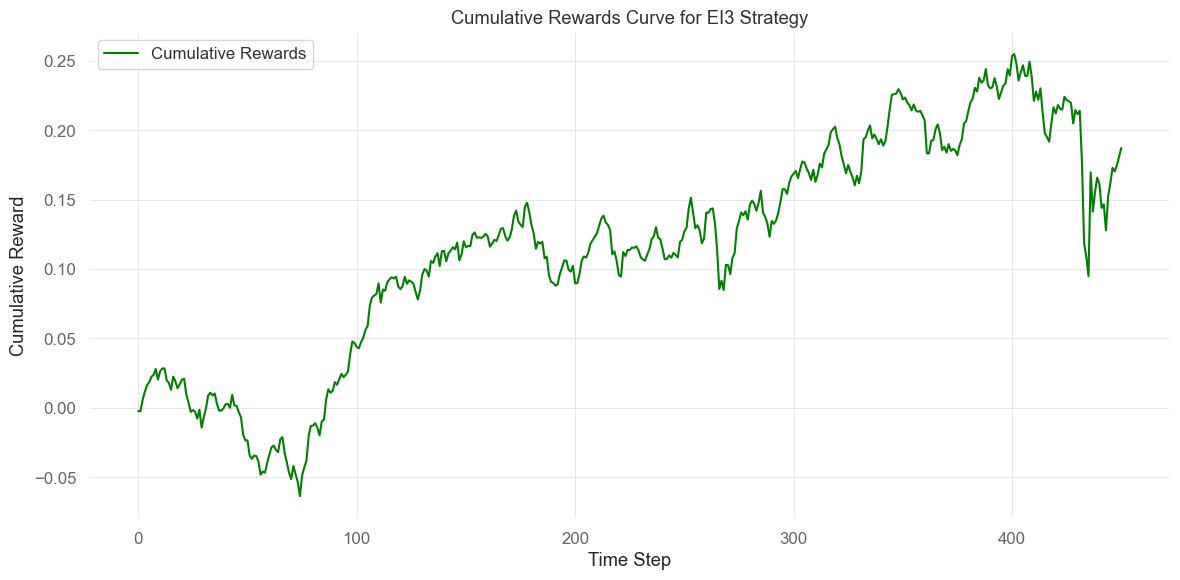

In [21]:
cumulative_rewards = np.cumsum(infosrewards)

# Plot the cumulative rewards curve
plt.figure(figsize=(12, 6))
plt.plot(cumulative_rewards, label="Cumulative Rewards", color="green")
plt.title("Cumulative Rewards Curve for EI3 Strategy")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

## Benchmarks


In [22]:
# Get portfolio values
eiie_values = test_env._asset_memory["final"]
bh_values = []

In [23]:
# Calculate Buy & Hold
test_env.reset()
action = [1 / len(tickers)] * len(tickers)
done = False
while not done:  # Use test_env._done to check episode completion
    test_obs, rewards, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated
    bh_values.append(test_env._portfolio_value)

Initial portfolio value:100000
Final portfolio value: 119186.734375
Final accumulative portfolio value: 1.1918673515319824
Maximum DrawDown: -0.14329297511030625
Sharpe ratio: 0.8027922416674209


In [24]:
risk_free_rate = 0.043  # 4.3% annualized

In [25]:
# Calculate metrics
def calculate_metrics(values, risk_free_rate):
    returns = pd.Series(values).pct_change().dropna()
    cumulative_return = (values[-1] / values[0]) - 1
    annualized_return = (1 + cumulative_return) ** (252 / len(returns)) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - risk_free_rate) / volatility
    max_drawdown = (values / np.maximum.accumulate(values) - 1).min()

    return {
        "Cumulative Return": cumulative_return,
        "Annualized Return": annualized_return,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
    }


eiie_metrics = calculate_metrics(eiie_values, risk_free_rate)
bh_metrics = calculate_metrics(bh_values, risk_free_rate)

In [26]:
metrics = [
    "Cumulative Return",
    "Annualized Return",
    "Volatility",
    "Sharpe Ratio",
    "Max Drawdown",
]

metrics_df = pd.DataFrame(
    {
        "Metric": metrics,
        "EIIE": [eiie_metrics[m] for m in metrics],
        "Buy & Hold": [bh_metrics[m] for m in metrics],
    }
)

## Performance Summary


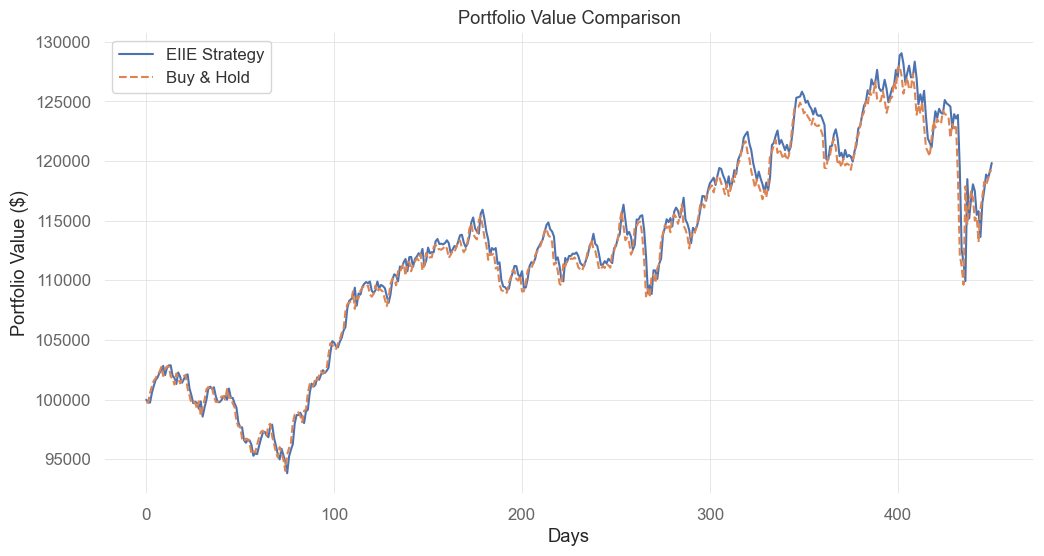

In [27]:
# Plot results
plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
plt.plot(eiie_values, label="EIIE Strategy")
plt.plot(bh_values, label="Buy & Hold", linestyle="--")
plt.title("Portfolio Value Comparison")
plt.xlabel("Days")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.show()
plt.close()

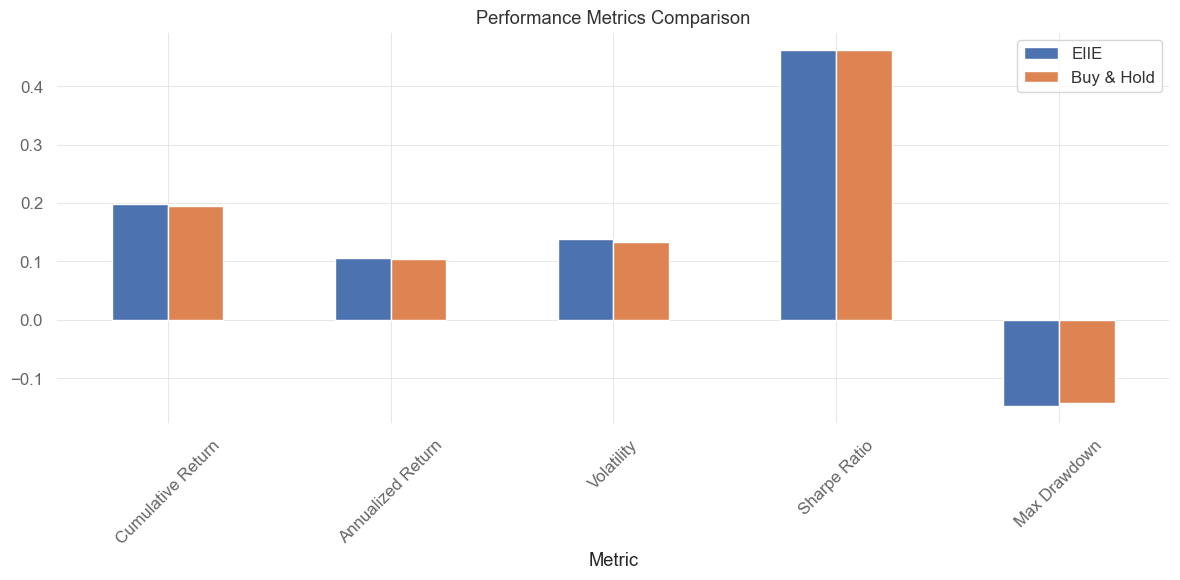

In [28]:
plt.figure(figsize=(12, 6))
metrics_df.set_index("Metric").plot(kind="bar", ax=plt.gca())
plt.title("Performance Metrics Comparison")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.close()

In [29]:
# Display metrics
print("\nPerformance Metrics:")
display(
    metrics_df.style.format(
        {
            "EIIE": "{:.2%}",
            "Buy & Hold": "{:.2%}",
            "Sharpe Ratio": "{:.2f}",
            "Volatility": "{:.2%}",
        }
    )
)


Performance Metrics:


,Metric,EIIE,Buy & Hold
0,Cumulative Return,19.84%,19.46%
1,Annualized Return,10.67%,10.47%
2,Volatility,13.79%,13.33%
3,Sharpe Ratio,46.16%,46.27%
4,Max Drawdown,-14.80%,-14.33%


In [30]:
# Additional Sharpe ratio optimization
log_returns = raw_df.pivot_table(index="date", columns="tic", values="close")
log_returns = np.log(log_returns.pct_change() + 1).dropna()
cov_matrix = log_returns.cov() * 252


def negative_sharpe(weights):
    port_return = np.dot(weights, log_returns.mean()) * 252
    port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
    return -(port_return - risk_free_rate) / port_vol


constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
bounds = [(0, 1) for _ in tickers]
initial_weights = np.array([1 / len(tickers)] * len(tickers))

result = minimize(
    negative_sharpe,
    initial_weights,
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
)

print("\nOptimal Weights from Sharpe Ratio Optimization:")
for ticker, weight in zip(tickers, result.x):
    print(f"{ticker}: {weight:.2%}")


Optimal Weights from Sharpe Ratio Optimization:
AXP: 33.79%
AMGN: 0.00%
AAPL: 0.00%
BA: 0.00%
CAT: 1.52%
CSCO: 0.00%
CVX: 0.00%
GS: 0.00%
HD: 0.00%
HON: 0.00%
IBM: 7.81%
INTC: 0.00%
JNJ: 0.00%
KO: 0.00%
JPM: 0.00%
MCD: 0.00%
MMM: 0.00%
MRK: 0.00%
MSFT: 0.00%
NKE: 0.00%
PG: 0.00%
TRV: 2.92%
UNH: 0.00%
CRM: 0.00%
VZ: 0.00%
V: 0.00%
WBA: 0.00%
WMT: 0.00%
DIS: 0.00%
DOW: 53.95%
